In [1]:
import sys
import os
import django
import shutil
from asgiref.sync import sync_to_async
import asyncio
from datetime import datetime, timezone
from datetime import timedelta
import numpy as np
import datetime
import joblib
import pandas as pd
import glob

# Absolute path to your Django project root (adjust this!)
project_path = "/home/pdapp/pd_api_server/"
sys.path.append(project_path)

# Set Django settings
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "mysite.settings")

# Setup Django
django.setup()

from django.contrib.auth.models import User
from api.models import Patient


# Make ORM calls async-safe
@sync_to_async
def get_patient(pid):
    patient = Patient.objects.get(patientId=pid)
    return patient


@sync_to_async
def get_patient_by_name(name):
    patient = Patient.objects.get(name=name)
    return patient

@sync_to_async
def get_pid():
    return list(Patient.objects.values_list('patientId', flat=True))

@sync_to_async
def get_patient_related_data(patient):
    user = User.objects.get(username=patient.user_name)
    
    data = {
        "date_join":user.date_joined,
        "patient": {
            "id": patient.patientId,
            "name": patient.name,
            "user_name": patient.user_name,
            "email": patient.email,
            "phone_no": patient.phone_no,
            "id_no": patient.id_no,
            "gender": patient.gender,
            "age": patient.age,
            "birthday": patient.birthday,
        },
        "records": [],
        "uploaded_files": [],
        "results": [],
        "questionnaires": [],
    }

    for r in patient.patientrecord_set.all():
        data["records"].append({
            "time": r.time,
            "taking_pd_medicine": r.taking_pd_medicine,
            "taking_pd_med3hr": r.taking_pd_med3hr,
        })

    for f in patient.fileuploaded_set.all():
        data["uploaded_files"].append({
            "upload_time": f.upload_time,
            "file_type": f.file_type,
            "file_path": f.file_path,
        })

    for res in patient.results_set.all():
        data["results"].append({
            "upload_time": res.upload_time,
            "gait_result": res.gait_result,
            "voice_result": res.voice_result,
            "hand_result": res.hand_result,
            "multimodal_results": res.multimodal_results,
        })

    for q in patient.patientquestionairerecord_set.all():
        data["questionnaires"].append({
            "time": q.time,
            "riskMarker": q.riskMarker,
            "PLR": q.PLR,
            "TELR": q.TELR,
            "PostProb": q.PostProb,
            "PPPD": q.PPPD,
            "response": q.response,
        })

    return data


@sync_to_async
def get_patient_questionnaires(patient):
    """
    Return only questionnaire records for a given patient.

    Args:
        patient: Patient model instance.

    Returns:
        list[dict]
    """
    qs = patient.patientquestionairerecord_set.all().order_by("time").values(
        "time",
        "riskMarker",
        "PLR",
        "TELR",
        "PostProb",
        "PPPD",
        "response",
    )
    return list(qs)



def get_latest_folder_by_creation_time(path):
    # List all subdirectories
    folders = [os.path.join(path, d) for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

    if not folders:
        return None

    # Get the folder with the most recent creation time
    latest_folder = max(folders, key=os.path.getctime)
    return latest_folder


# ---- Helper to normalize/expand responses ----

def _coerce_response_list(resp):
    """
    Stored 'response' may be a JSON string or already a list[dict].
    This normalizes it to list[dict] or returns [] if invalid.
    """
    if resp is None:
        return []
    if isinstance(resp, list):
        return resp
    if isinstance(resp, str):
        import json
        try:
            parsed = json.loads(resp)
            return parsed if isinstance(parsed, list) else []
        except Exception:
            return []
    return []

def expand_responses_for_records(records, question_bank, include_weights=True):
    """
    records: list of dicts from get_patient_questionnaires(patient)
             each record has keys: time, riskMarker, PLR, TELR, PostProb, PPPD, response
    question_bank: dict[int -> Question], where Question has:
                   .text (or .prompt), .options (list[str]), .weights (list[float]), .category (str)

    Returns: new list where each record has:
      - all original keys EXCEPT 'response'
      - 'qa': list of dicts:
          {
            'id': int,                      # question id
            'question': str,                # question text
            'answer_index': int,            # 1-based index from stored data
            'answer': str | None,           # mapped option text (None if out-of-range)
            'category': str | None,         # category from question bank
            'weight': float | None          # optional, if include_weights=True and available
          }
    """
    out = []
    for rec in records:
        resp_list = _coerce_response_list(rec.get("response"))
        qa = []
        for item in resp_list:
            qid = item.get("question")
            ans_idx_1b = item.get("response")  # stored 1-based
            q = question_bank.get(qid)

            question_text = None
            options = None
            weights = None
            category = None

            if q is not None:
                # Support either .text/.prompt attributes or tuple-like storage
                question_text = getattr(q, "text", None) or getattr(q, "prompt", None) or getattr(q, "__doc__", None)
                if question_text is None and isinstance(q, tuple) and len(q) >= 1:
                    question_text = q[0]
                options = getattr(q, "options", None)
                if options is None and isinstance(q, tuple) and len(q) >= 2:
                    options = q[1]
                weights = getattr(q, "weights", None)
                if weights is None and isinstance(q, tuple) and len(q) >= 3:
                    weights = q[2]
                category = getattr(q, "category", None)
                if category is None and isinstance(q, tuple) and len(q) >= 4:
                    category = q[3]

            # Map 1-based index to option text safely
            answer_text = None
            weight_val = None
            if isinstance(ans_idx_1b, int) and options and 1 <= ans_idx_1b <= len(options):
                answer_text = options[ans_idx_1b - 1]
                if include_weights and weights and 1 <= ans_idx_1b <= len(weights):
                    weight_val = weights[ans_idx_1b - 1]

            qa.append({
                "id": qid,
                "question": question_text,
                "answer_index": ans_idx_1b,
                "answer": answer_text,
                "category": category,
                "weight": weight_val if include_weights else None
            })

        # keep other fields, drop original 'response'
        new_rec = {k: v for k, v in rec.items() if k != "response"}
        new_rec["qa"] = qa
        out.append(new_rec)
    return out


def records_to_dataframe(records, question_bank):
    """
    Flatten questionnaire records into a DataFrame with one column per question.
    
    Args:
        records: list of dicts (expanded records that include 'qa')
        question_bank: dict[int -> question dict with 'text' key]
        
    Returns:
        pd.DataFrame
    """
    rows = []
    for rec in records:
        row = {
            "time": rec.get("time"),
            "PostProb": rec.get("PostProb"),
            "PPPD": rec.get("PPPD"),
        }
        for qa_item in rec.get("qa", []):
            qid = qa_item["id"]
            qtext = question_bank[qid]["text"] if qid in question_bank else f"Q{qid}"
            row[qtext] = qa_item.get("answer")
        rows.append(row)
    
    df = pd.DataFrame(rows)
    return df


def question_bank_to_json(qbank):
    out = {}
    for k, q in qbank.items():
        if isinstance(q, dict):
            out[k] = q
        else:
            out[k] = {
                "text": getattr(q, "text", f"Q{k}"),
                "options": getattr(q, "options", []),
                "weights": getattr(q, "weights", []),
                "category": getattr(q, "category", None),
            }
    return out



class Question:
    def __init__(self, text, options, weights, category):
        self.text = text
        self.options = options
        self.weights = weights
        self.category = category

    def __repr__(self):
        return f"Question({self.text!r}, {len(self.options)} options, category={self.category!r})"

QUESTION_BANK = {
  1: Question(
      '請問您的年齡：',
      ['50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '>=80'],
      [0.0040, 0.00750, 0.01250, 0.020, 0.0250, 0.0350, 0.040],
      'Prior Probability'),
  2: Question('(1)	您的性別：', ['男性', '女性'], [1.2, 0.8], 'Risk Markers'),
  3: Question('(2)	過去是否曾接觸殺蟲劑(Regular Pesticide Exposure)(例如：>=100次非職業性接觸)： ',
      ['是', '否', '不知道或是無法取得資訊'], [1.5, 1.0, 1.0], 'Risk Markers'),
  4: Question('(3)	職業或是居住環境是否會接觸到化學溶劑(Occupational Solvent Exposure)：',
      ['是', '否', '不知道或是無法取得資訊'], [1.5, 1.0, 1.0], 'Risk Markers'),
  5: Question(
      '(4)	是否長期攝取含咖啡因飲料(Consume Caffeinated Beverage)：',
      ['是 (每周大於3杯咖啡或是6杯紅茶)', '否 (每周小於3杯咖啡或是6杯紅茶)', '不知道或是無法取得資訊'],
      [0.88, 1.35, 1.0],
      'Risk Markers'),
  6: Question(
      '(5)	是否抽菸(Smoking)：',
      [
        '從未 (Never)',
        '已戒菸 (Former)',
        '仍在抽菸（Current）',
        '不知道或是無法取得資訊 (Not Available)'
      ],
      [1.2, 0.91, 0.51, 1.0],
      'Risk Markers'),
  7: Question('(6)	家族一等親(父母或是兄弟姊妹)是否有罹患巴金森症的患者：', ['是', '否', '不知道或是無法取得資訊'],
      [2.5, 1.0, 1.0], 'Risk Markers'),
  8: Question('a.	GBA基因變異 (Anheim 2012, Neurology)：', ['是', '否', '不知道或是無法取得資訊'],
      [20.0, 1.0, 1.0], 'Risk Markers'),
  9: Question('b.	LRRK2 (p.G2019S)基因變異(Lee 2017, Mov Disord)：',
      ['是', '否', '不知道或是無法取得資訊'], [2.5, 1.0, 1.0], 'Risk Markers'),
  10: Question(
      '(7-2) 多基因風險分數(Polygenetic Risk Score)：',
      [
        '高風險分數(例如: 分數在大型世代追蹤族群中的最前四分之一)',
        '低風險分數(例如: 分數在大型世代追蹤族群中的最後四分之一)',
        '不知道或是無法取得資訊'
      ],
      [1.57, 0.45, 1.0],
      'Risk Markers'),
  11: Question(
      '(8)	穿顱超音波檢查顯示黑質有高回聲訊號(Documented Substantia Nigra Hyperechogenicity on Transcranial Ultrasound)(例如：訊號強度大於90個百分比的參考樣本的單側或雙側黑質高回聲訊號)：',
      ['是', '否', '不知道或是無法取得資訊'],
      [3.4, 0.38, 1.0],
      'Risk Markers'),
  12: Question('(9)	是否具有第二型糖尿病：', ['是', '否', '不知道或是無法取得資訊'], [1.5, 0.97, 1.0],
      'Risk Markers'),
  13: Question('(10)	是否活動力不足(例如：每週進行能使呼吸及心跳速率上升/流汗的活動次數小於1小時)：',
      ['是', '否', '不知道或是無法取得資訊'], [1.3, 0.91, 1.0], 'Risk Markers'),
  14: Question('(11)	如果您是男性，血液中尿酸濃度是否偏低：', ['是', '否', '不知道或是無法取得資訊'],
      [1.8, 0.88, 1.0], 'Risk Markers'),
  15: Question(
      'A-1.1 您是否有睡眠多項生理檢查證實的快速動眼期睡眠動作障礙?(睡覺時會對夢境內容大喊大叫，甚至拳打腳踢)：',
      ['是', '否', '不知道或是無法取得資訊'],
      [130, 0.65, 1.0],
      'Clinical Non-motor Markers'),
  16: Question(
      'A-1.2 您的快速動眼期睡眠動作障礙 (睡覺時會對夢境內容大喊大叫，甚至拳打腳踢)是否可以排除其他的可能?\n(其他鑑別診斷、藥物誘發/猝睡症相關動作症狀需被排除)：',
      ['是', '否'],
      [1.0, 0.0],
      'Clinical Non-motor Markers'),
  17: Question(
      '快速動眼期睡眠動作障礙篩檢結果為：',
      ['陽性。無進一步檢驗確認', '陰性。無進一步檢驗確認', '不知道或是無法取得資訊'],
      [2.8, 0.89, 1.0],
      'Clinical Non-motor Markers'),
  18: Question('A-2 日間嗜睡(可能的藥物誘發嗜睡或是猝睡症相關症狀需被排除)：', ['是', '否', '不知道或是無法取得資訊'],
      [2.7, 0.86, 1.0], 'Clinical Non-motor Markers'),
  19: Question(
      'A-3 您的嗅覺功能是否下降或是喪失? (例如：量化嗅覺測驗，如：Sniffin’ Stick, UPSIT或B-SIT，總分低於年紀及性別調整後之閾值)：',
      ['是', '否', '不知道或是無法取得資訊'],
      [6.4, 0.4, 1.0],
      'Clinical Non-motor Markers'),
  20: Question(
      'A-4 您是否有便秘情況? (便秘症狀至少需要每週一次的吃軟便藥治療，或自然排便頻率低於兩天一次)：',
      ['是', '否', '不知道或是無法取得資訊'],
      [2.5, 0.82, 1.0],
      'Clinical Non-motor Markers'),
  21: Question('A-5 您是否有泌尿功能失調症狀? (排尿不順或是夜間頻尿)：', ['是', '否', '不知道或是無法取得資訊'],
      [2.0, 0.9, 1.0], 'Clinical Non-motor Markers'),
  22: Question(
      'A-6 若您是男性，是否有嚴重勃起障礙(Severe Erectile Dysfunction)：',
      ['是', '否', '不知道或是無法取得資訊', '女性病患'],
      [3.4, 0.87, 1.0, 1.0],
      'Clinical Non-motor Markers'),
  23: Question('A-7 是否有姿態性低血壓(Orthostatic Hypotension)：', ['是', '否'], [1, 0],
      'Clinical Non-motor Markers'),
  24: Question(
      '姿態性低血壓(Orthostatic Hypotension)結果：',
      [
        '姿態性低血壓，且經專家全面性評估後無其他可能原因',
        '有姿態性低血壓紀錄，但未經進一步檢查評估',
        '經專家全面性評估後無姿態性低血壓',
        '無姿態性低血壓紀錄，且無進一步檢查評估',
        '不知道或是無法取得資訊'
      ],
      [18.5, 3.2, 0.88, 0.80, 1.0],
      'Clinical Non-motor Markers'),
  25: Question(
      'A-8 是否有憂鬱症狀?(有/無合併焦慮症狀) (臨床診斷或是憂鬱量表/問卷達中等以上嚴重程度)：',
      ['是', '否', '不知道或是無法取得資訊'],
      [1.6, 0.88, 1.0],
      'Clinical Non-motor Markers'),
  26: Question('A-9 您是否有認知功能降低? (例如：被診斷輕度認知障礙)：', ['是', '否', '不知道或是無法取得資訊'],
      [1.8, 0.88, 1.0], 'Clinical Non-motor Markers'),
  27: Question('B-1 巴金森氏病量表(UPDRS)第三部分總分大於6分 (需排除動作誘發顫抖及其他潛在干擾因子，例如：關節炎)：',
      ['是', '否', '不知道或是無法取得資訊'], [9.6, 0.55, 1.0], 'Clinical Motor Markers'),
  28: Question(
      'B-2 量化動作測驗呈現異常結果 (Abnormal Quantitative Motor Testing) (異常結果應依據不同測試的閾值，低於其年紀調整後常模的1個標準差。選用的量化動作測驗應可清楚呈現巴金森氏病患者的異常，且相較於控制組有80%以上的專一性。若是選用多個量化動作測驗，個案應有超過一半的測驗結果呈現異常。不確定或於臨界值的結果皆不應納入計算)：',
      ['是', '否', '不知道或是無法取得資訊'],
      [3.5, 0.6, 1.0],
      'Clinical Motor Markers'),
  29: Question('C-1 多巴胺攝影影像結果呈現明顯異常 (TRODAT 核醫影像) (例如：小於65%的正常結果或是低於平均兩個標準差)：',
      ['是', '否', '不知道或是無法取得資訊'], [43.3, 0.66, 1], 'Clinical Biomarkers'),
};

QUESTION_BANK_JSON = question_bank_to_json(QUESTION_BANK)


In [3]:
# # fetch patients results video and analysised features

# ls = [
#     "20250415_151810",
#     "20250527_134430",
#     "20250527_152010",
#     "20250603_135512",
# ]
# results_pth = "/mnt/pd_app/results/"

# for p_name in ls:
#     src = results_pth + p_name
#     dst = f"/mnt/pd_app/fetch_results/{p_name}"
#     try:
#         shutil.copytree(src, dst)
#     except:
#         print(f"{p_name} failed to copy")
        

In [4]:
## fetch patient data

# ls = [
#     "20250415_135222",
#     "20250519_154625",
#     "20250527_104232",
#     "20250610_134943",
#     "20250617_153024",
#     "20250704_141036",
#     "20250707_144520",
#     "20250707_164341",
#     "20250707_162327",
#     "20250708_142320",
#     "20250708_152651",
#     "20250711_135647",
#     "20250722_163856",
#     "20250728_145216",
#     "20250804_152504",
#     "20250812_152958",
#     "20250815_140221",
#     "20250818_151857",
# ]


# for p_name in ls:
#     try:
#         patient = await get_patient_by_name(p_name)
#         data = await get_patient_related_data(patient)

#         if os.path.isdir(f"/mnt/pd_app/fetch/{p_name}"):
#             pass
#         else:
#             os.mkdir(f"/mnt/pd_app/fetch/{p_name}")


#         hand_pth = "/mnt/pd_app/gesture/"
#         sound_pth = "/mnt/pd_app/sound/"
#         walk_pth = "/mnt/pd_app/walk/"

#         for item in data["uploaded_files"]:

#             file_name = item["file_path"] 

#             if item["file_type"] == "right_hand" or item["file_type"] == "left_hand":

#                 if "旋轉" not in file_name:

#                     hand_src_file = hand_pth + file_name
#                     hand_dst_file = f"/mnt/pd_app/fetch/{p_name}/{file_name}"

#                     if os.path.isfile(hand_src_file):
#                         shutil.copy(hand_src_file, hand_dst_file)
#                     else:
#                         print(f"missing data, p_name: {p_name}")

#             elif item["file_type"] == "sound" and "freetalk" not in file_name:

#                 sound_src_file = sound_pth + file_name
#                 sound_dst_file = f"/mnt/pd_app/fetch/{p_name}/{file_name}"

#                 if os.path.isfile(sound_src_file):
#                     shutil.copy(sound_src_file, sound_dst_file)
#                 else:
#                     print(f"missing data, p_name: {p_name}")

#             elif item["file_type"] == "gait":

#                 gait_src_file = walk_pth + file_name
#                 gait_dst_file = f"/mnt/pd_app/fetch/{p_name}/{file_name}"

#                 if os.path.isfile(gait_src_file):
#                     shutil.copy(gait_src_file, gait_dst_file)
#                 else:
#                     print(f"missing data, p_name: {p_name}")
#     except:
#         print(p_name)


In [5]:
# patient = await get_patient_by_name("20250708_152651")
# data = await get_patient_related_data(patient)

In [6]:
# for p_name in ls:

#     result_pth = "/mnt/pd_app/result/"

#     src_file = result_pth + p_name
#     dst_file = f"/mnt/pd_app/fetch/{p_name}/"

#     if os.path.isfile(src_file):
#         shutil.copy(src_file, dst_file)
#     else:
#         print(f"missing data, p_name: {p_name}")



In [10]:
q_ls = [
    "20251017_110524"
]


all_patient_questionnaire = {}

for p_name in q_ls:
    try:
        patient = await get_patient_by_name(p_name)
        raw_records = await get_patient_questionnaires(patient)   # list[dict], includes 'response'
        expanded = expand_responses_for_records(raw_records, QUESTION_BANK, include_weights=True)
        all_patient_questionnaire[patient.name] = expanded
    except Exception as e:
        print(f"error loading {p_name} data. {e}")
        

all_dfs = []

for pname, records in all_patient_questionnaire.items():
    df = records_to_dataframe(records, QUESTION_BANK_JSON)
    df.insert(0, "patient", pname)   # add patient column
    all_dfs.append(df)

final_df = pd.concat(all_dfs, ignore_index=True)
final_df = final_df.set_index("patient")

final_df.to_csv("../../pdapp/questionale_data_20251021.csv", index=False, encoding="utf-8-sig")

In [ ]:
# df = pd.DataFrame(ls)
# df.columns = ["patient"]
# df.set_index('patient').join(final_df).reset_index().to_csv("../questionale_data.csv", index=False, encoding="utf-8-sig")
# final_df.loc[set(ls).intersection(set(final_df.index)),:].sort_index().reset_index().to_csv("../questionale_data.csv", index=False, encoding="utf-8-sig")

In [10]:
# # get the features input

# p_name = [
#     "NTUH002_20250303_1",
#     "20250327_091551",
#     "20250327_094148",
#     "20250327_102000",
#     "20250327_114817",
#     "20250331_134903",
#     "20250331_140420",
#     "20250331_143828",
#     "20250331_152729",
#     "20250331_160904",
#     "20250331_165049",
#     "20250401_140936",
#     "20250401_145545",
#     "20250401_153600",
#     "20250401_162029",
#     "20250401_162100",
#     "20250407_135508",
#     "20250407_151015",
#     "20250407_160315",
#     "20250408_134919",
#     "20250408_144856",
#     "20250408_152403",
#     "20250411_134712",
#     "20250411_150142",
#     "20250411_154512",
#     "20250411_162808",
#     "20250414_134215",
#     "20250414_144409",
#     "20250414_144804",
#     "20250414_155148",
#     "20250415_135222",
#     "20250415_151810",
#     "20250415_154810",
#     "20250418_142843",
#     "20250418_154150",
#     "20250421_135406",
#     "20250421_145854",
#     "20250422_143040",
#     "20250422_154353",
#     "20250422_161104",
#     "20250425_141922",
#     "20250425_152013",
#     "20250428_144203",
#     "20250429_142745",
#     "20250429_154157",
#     "20250505_135432",
#     "20250505_145451",
#     "20250506_140256",
#     "20250506_145321",
#     "20250506_154515",
#     "20250513_144106",
#     "20250513_155455",
#     "20250519_154625",
#     "20250519_161049",
#     "20250520_134524",
#     "20250520_144118",
#     "20250520_151843",
#     "20250527_134430",
#     "20250527_144231",
#     "20250527_152010",
#     "20250529_091404",
#     "20250527_104232",
#     "20250602_140610",
#     "20250602_145529",
#     "20250602_160634",
#     "20250603_135512",
#     "20250603_144132",
#     "20250603_152919",
#     "20250609_134344",
#     "20250609_142920",
#     "20250609_153125",
#     "20250610_134943",
#     "20250610_144515",
#     "20250616_134909",
#     "20250616_143452",
#     "20250616_152801",
#     "20250617_135432",
#     "20250617_143418",
#     "20250617_153024",
#     "20250620_151526",
#     "20250620_161020",
#     "20250624_102121",
#     "20250624_144848",
#     "20250627_142531",
#     "20250627_151710",
#     "20250701_140245",
#     "20250701_145616",
#     "20250704_141036",
#     "20250707_144520",
#     "20250707_164341",
#     "20250707_162327",
#     "20250708_142320",
#     "20250708_152651",
#     "20250711_135647",
#     "20250711_150053",
#     "20250711_150145",
#     "20250714_140649",
#     "20250714_154408",
#     "20250714_155141",
#     "20250715_143930",
#     "20250718_140731",
#     "20250718_151020",
#     "20250722_152734",
#     "20250722_163856",
#     "20250724_092104",
#     "20250728_145216",
#     "20250729_135252",
#     "20250729_140812",
#     "20250729_162601",
#     "20250804_141453",
#     "20250804_152504",
#     "20250804_152757",
#     "20250805_141247",
#     "20250805_152340",
#     "20250805_152401",
#     "20250811_151440",
#     "20250812_135943",
#     "20250812_152958",
#     "20250812_153109",
#     "20250815_140152",
#     "20250815_140221",
#     "20250815_152147",
#     "20250818_151857",
#     "20250819_140820",
#     "20250821_091556",
#     "20250825_150327",
#     "20250825_150352",
#     "20250828_095815",
#     "20250829_151113",
#     "20250902_145037",
#     "NTUH002_20250306_4",
#     "20250605_113336",
#     "20250623_150000",
# ]



# result_pth = "/mnt/pd_app/results/"

# gait_feature_name = ['left_foot_ground', 'right_foot_ground', 'left_right_foot_len_average', 'left_right_foot_len_max',
#                      'left_turning_duration', 'left_turning_slope', 'right_turning_duration', 'right_turning_slope',
#                      'l_leg_max_angles', 'l_leg_min_angles', 'r_leg_max_angles', 'r_leg_min_angles', 'l_arm_max_angles',
#                      'l_arm_min_angles', 'r_arm_max_angles', 'r_arm_min_angles', 'core_max_angles', "core_min_angles",
#                      'average_duration_per_rounds', "duration_change", "l_mean_steps", "r_mean_steps"]

# hand_features_name = [ "Right Tapping Time", "Right Tapping Time Change", "Right Tapping Distance", "Left Tapping Time",
#                        "Left Tapping Time Change", "Left Tapping Distance", "Left Tapping Frequency", 
#                        "Left Tapping Intensity", "Left Tapping Power", "Left Tapping Frequency Change",
#                        "Right Tapping Frequency", "Right Tapping Intensity", "Right Tapping Power", "Right Tapping Frequency Change"]

# voice_feature_name = ['reading_time' , 'score', 'pause(%)', 'volume change', 'pitch change', 'Average pitch']
# gait_len = len(gait_feature_name)
# hand_len = len(hand_features_name)
# voice_len = len(voice_feature_name)

# df_dt = {}

# for name in p_name:
#     try:
#         result_folder = result_pth + name + "/"

#         # Get all subfolders
#         folders = [f for f in glob.glob(os.path.join(result_folder, "*")) if os.path.isdir(f)]

#         # Sort by creation time (newest first)
#         latest_folder = max(folders, key=os.path.getctime)

#         file = latest_folder + "/" + "all_feature.npy"


#         data = np.load(file)
#         gait_feature = data[:gait_len]
#         hand_feature = data[gait_len:gait_len + hand_len]
#         voice_feature = data[-voice_len:]

#         df_dt[name] = gait_feature
#     except:
#         df_dt[name] = np.zeros(gait_len)

Text(0.5, 1.0, 'New Dataset Average Duration Per Rounds')

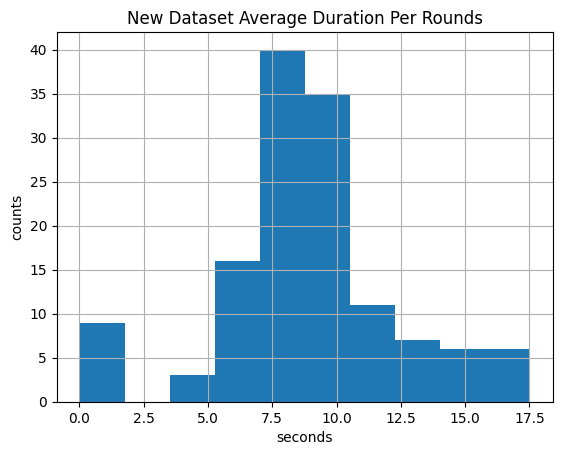

In [16]:
# df = pd.DataFrame.from_dict(df_dt).T
# df.columns = gait_feature_name

# ax = df["average_duration_per_rounds"].hist()
# ax.set_xlabel('seconds')
# ax.set_ylabel('counts')
# ax.set_title('New Dataset Average Duration Per Rounds')